In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import accuracy_score

In [3]:
np.random.seed(1)

In [4]:
def linear_kernel(X, Y):
    return X @ Y.T

def rbf_kernel(X, Y, gamma):
    x_norm = np.sum(X**2, axis=1).reshape(-1, 1)
    y_norm = np.sum(Y**2, axis=1).reshape(1, -1)
    sqdist = x_norm + y_norm - 2 * X @ Y.T
    return np.exp(-gamma * sqdist)

def poly_kernel(X, Y, degree=3, coef0=1):
    return (X @ Y.T + coef0) ** degree

In [5]:
class TinySMO:
    def __init__(self, C=1.0, kernel='rbf', kernel_params=None, tol=1e-3, max_passes=20):
        self.C = float(C)
        self.kernel_name = kernel
        self.kernel_params = kernel_params or {}
        self.tol = tol
        self.max_passes = max_passes

        self.alpha = None
        self.b = 0.0
        self.X = None
        self.y = None
        self.K = None

    def _kernel(self, X, Y=None):
        if Y is None: Y = X
        if self.kernel_name == 'linear':
            return linear_kernel(X, Y)
        if self.kernel_name == 'rbf':
            gamma = self.kernel_params.get('gamma', 1.0)
            return rbf_kernel(X, Y, gamma)
        if self.kernel_name == 'poly':
            degree = self.kernel_params.get('degree', 3)
            coef0 = self.kernel_params.get('coef0', 1)
            return poly_kernel(X, Y, degree=degree, coef0=coef0)
        raise ValueError("Unknown kernel")

    def fit(self, X, y):
        # X: nxd, y: 0/1 or -1/+1 -> convert to -1/+1
        n = X.shape[0]
        self.X = X.copy()
        y2 = y.copy()
        y2 = np.where(y2 <= 0, -1, y2)
        self.y = y2.astype(float)

        # precompute kernel matrix
        self.K = self._kernel(self.X, self.X)

        alpha = np.zeros(n)
        b = 0.0
        passes = 0

        # helper: prediction error
        def f(i):
            return np.sum(alpha * self.y * self.K[:, i]) + b

        def E(i):
            return f(i) - self.y[i]

        # SMO main loop with heuristic pair selection:
        while passes < self.max_passes:
            num_changed = 0
            for i in range(n):
                E_i = E(i)
                r_i = E_i * self.y[i]
                if (r_i < -self.tol and alpha[i] < self.C) or (r_i > self.tol and alpha[i] > 0):
                    # pick j: heuristic - maximize |E_i - E_j|
                    non_i = [k for k in range(n) if k != i]
                    E_vals = np.array([E(k) for k in non_i])
                    # choose j with largest |E_i - E_j|
                    j = non_i[np.argmax(np.abs(E_i - E_vals))]
                    E_j = E(j)

                    alpha_i_old = alpha[i]
                    alpha_j_old = alpha[j]

                    # compute bounds L, H
                    if self.y[i] != self.y[j]:
                        L = max(0, alpha[j] - alpha[i])
                        H = min(self.C, self.C + alpha[j] - alpha[i])
                    else:
                        L = max(0, alpha[i] + alpha[j] - self.C)
                        H = min(self.C, alpha[i] + alpha[j])
                    if L == H:
                        continue

                    # compute eta
                    eta = 2.0 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                    if eta >= 0:
                        # fallback: small step (rare)
                        continue

                    # update j (unclipped -> clip)
                    alpha[j] = alpha_j_old - (self.y[j] * (E_i - E_j)) / eta
                    alpha[j] = np.clip(alpha[j], L, H)
                    if abs(alpha[j] - alpha_j_old) < 1e-12:
                        alpha[j] = alpha_j_old
                        continue

                    # update i
                    alpha[i] = alpha_i_old + self.y[i] * self.y[j] * (alpha_j_old - alpha[j])

                    # update bias
                    b1 = b - E_i - self.y[i] * (alpha[i] - alpha_i_old) * self.K[i, i] - self.y[j] * (alpha[j] - alpha_j_old) * self.K[i, j]
                    b2 = b - E_j - self.y[i] * (alpha[i] - alpha_i_old) * self.K[i, j] - self.y[j] * (alpha[j] - alpha_j_old) * self.K[j, j]
                    if 0 < alpha[i] < self.C:
                        b = b1
                    elif 0 < alpha[j] < self.C:
                        b = b2
                    else:
                        b = 0.5 * (b1 + b2)

                    num_changed += 1

            if num_changed == 0:
                passes += 1
            else:
                passes = 0

        self.alpha = alpha
        self.b = b
        sv_mask = alpha > 1e-8
        self.support_indices = np.where(sv_mask)[0]
        self.support_vectors_ = self.X[self.support_indices]
        self.support_alphas_ = alpha[self.support_indices]
        self.support_y_ = self.y[self.support_indices]
        return self

    def decision_function(self, X_test):
        Kt = self._kernel(X_test, self.X)
        return (Kt @ (self.alpha * self.y)) + self.b

    def predict(self, X_test):
        return np.sign(self.decision_function(X_test))

In [6]:
def plot_boundary(model, X, y, title=None, mesh_res=200):
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, mesh_res), np.linspace(y_min, y_max, mesh_res))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.decision_function(grid).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    # contours at margins -1,0,1
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--','-','--'])
    plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', edgecolors='k')
    if hasattr(model, 'support_indices'):
        sv = model.support_vectors_
        # hollow circle to mark support vectors
        plt.scatter(sv[:,0], sv[:,1], s=120, facecolors='none', linewidths=1.6, zorder=10)
    if title:
        plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

In [7]:
def demo():
    datasets = {
        'blobs': make_blobs(n_samples=150, centers=2, random_state=2, cluster_std=1.2),
        'moons': make_moons(n_samples=150, noise=0.15, random_state=2),
        'circles': make_circles(n_samples=150, noise=0.08, factor=0.5, random_state=2)
    }

    for name, (X, y) in datasets.items():
        print(f"\n=== {name} ===")
        X = (X - X.mean(axis=0)) / X.std(axis=0)

        # linear
        m1 = TinySMO(C=1.0, kernel='linear', kernel_params={}, max_passes=15)
        m1.fit(X, y)
        print("linear: #SV =", len(m1.support_indices))
        plot_boundary(m1, X, y, title=f"{name} - linear (C=1)")

        # rbf
        m2 = TinySMO(C=1.0, kernel='rbf', kernel_params={'gamma':0.8}, max_passes=15)
        m2.fit(X, y)
        print("rbf(gamma=0.8): #SV =", len(m2.support_indices))
        plot_boundary(m2, X, y, title=f"{name} - rbf gamma=0.8 (C=1)")

        # poly
        m3 = TinySMO(C=1.0, kernel='poly', kernel_params={'degree':3, 'coef0':1}, max_passes=15)
        m3.fit(X, y)
        print("poly(deg=3): #SV =", len(m3.support_indices))
        plot_boundary(m3, X, y, title=f"{name} - poly deg=3 (C=1)")

In [8]:
def sv_count_experiments():
    X, y = make_moons(n_samples=150, noise=0.15, random_state=2)
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    Cs = [0.01, 0.1, 1, 5, 10, 50]
    sv_counts_C = []
    for C in Cs:
        model = TinySMO(C=C, kernel='rbf', kernel_params={'gamma':0.8}, max_passes=15)
        model.fit(X, y)
        sv_counts_C.append(len(model.support_indices))

    plt.figure(figsize=(6,4))
    plt.plot(Cs, sv_counts_C, marker='o')
    plt.xscale('log')
    plt.xlabel('C (log scale)')
    plt.ylabel('# support vectors')
    plt.title('#SV vs C (RBF gamma=0.8)')
    plt.show()

    gammas = [0.1, 0.3, 0.8, 1.5, 3.0]
    sv_counts_g = []
    for g in gammas:
        model = TinySMO(C=1.0, kernel='rbf', kernel_params={'gamma':g}, max_passes=15)
        model.fit(X, y)
        sv_counts_g.append(len(model.support_indices))

    plt.figure(figsize=(6,4))
    plt.plot(gammas, sv_counts_g, marker='o')
    plt.xlabel('gamma (RBF)')
    plt.ylabel('# support vectors')
    plt.title('#SV vs gamma (C=1.0)')
    plt.show()


=== blobs ===
linear: #SV = 4


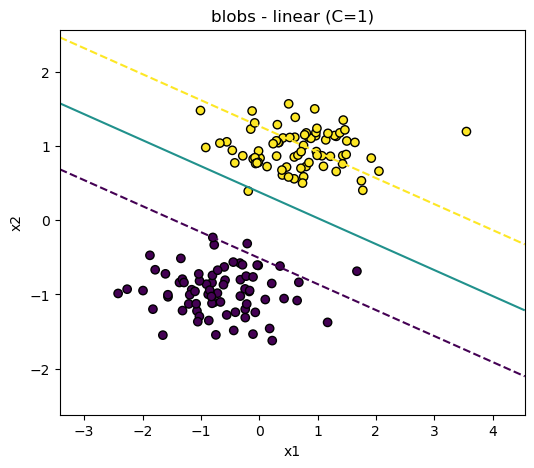

rbf(gamma=0.8): #SV = 10


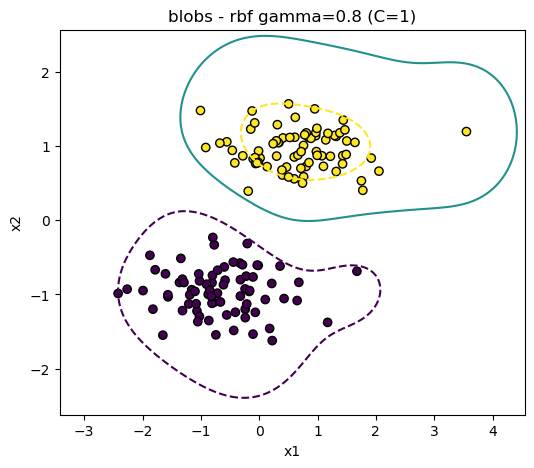

poly(deg=3): #SV = 4


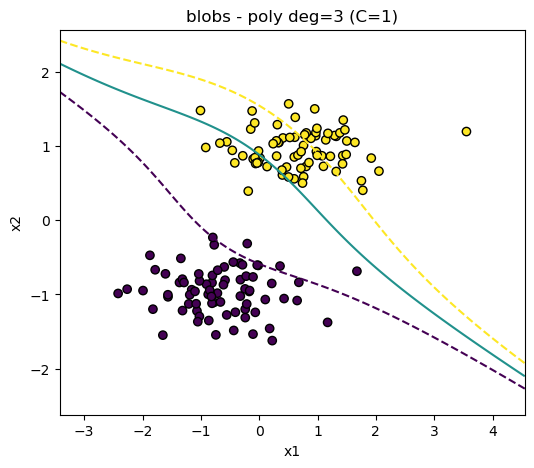


=== moons ===
linear: #SV = 8


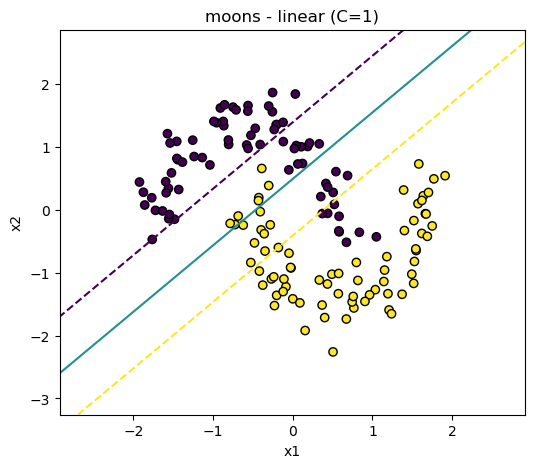

rbf(gamma=0.8): #SV = 16


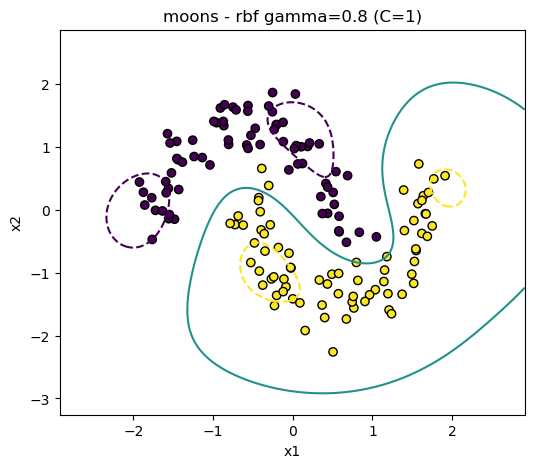

poly(deg=3): #SV = 2


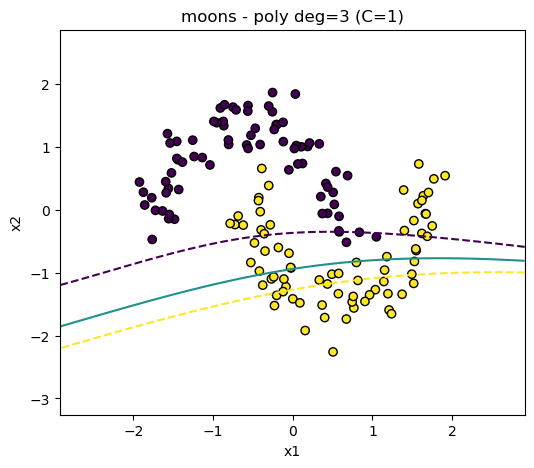


=== circles ===
linear: #SV = 43


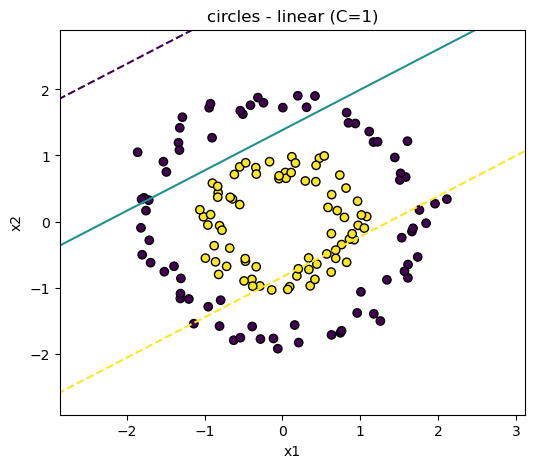

rbf(gamma=0.8): #SV = 24


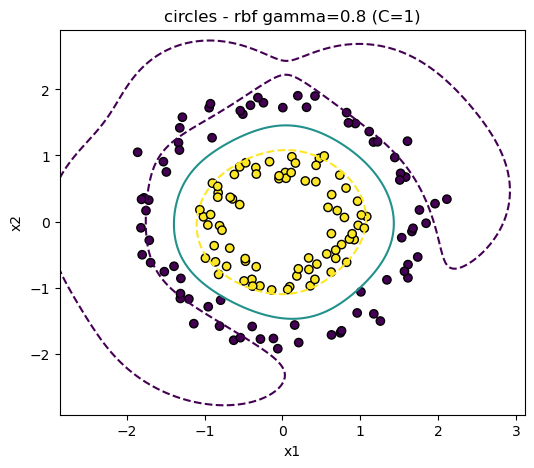

poly(deg=3): #SV = 24


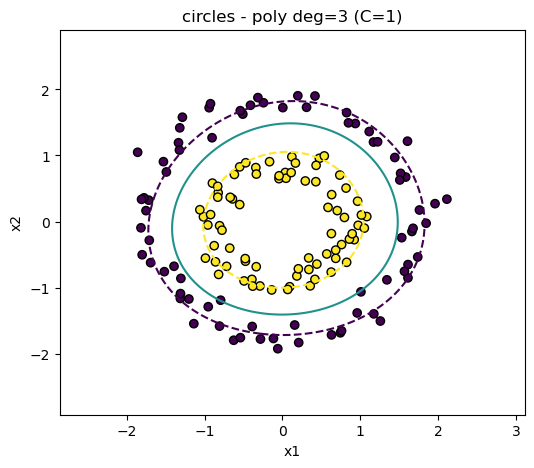

In [9]:
demo()

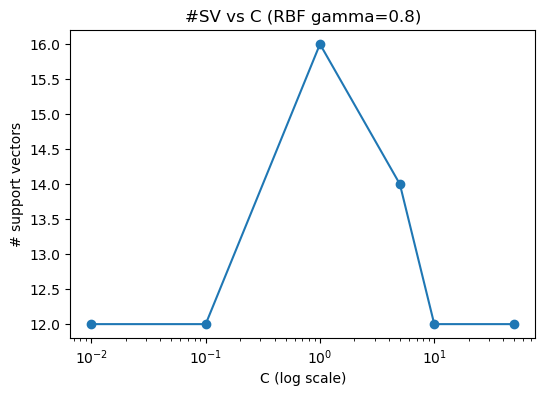

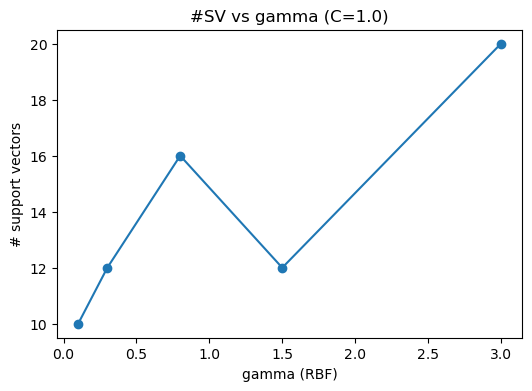

In [10]:
sv_count_experiments()